In [1]:
# 🛰️ Import libraries
import ee
import geemap

# 🌐 Authenticate & initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='urban-expansion-study-2025')

# 📍 Define Rivers State (Port Harcourt) boundary using FAO GAUL
portharcourt = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Rivers')) \
    .geometry()

# 🛰️ Load Sentinel-5P NO₂ dataset (Jan 2019 – June 2025)
no2_dataset = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select('NO2_column_number_density') \
    .filterDate('2019-01-01', '2025-06-12') \
    .filterBounds(portharcourt)

# 📊 Compute median NO₂ concentration
no2_median = no2_dataset.median().clip(portharcourt)

# 🎨 Visualization parameters
vis_params = {
    'min': 0,
    'max': 0.0002,
    'palette': ['black', 'purple', 'blue', 'green', 'yellow', 'red']
}

# 🗺️ Display map
Map = geemap.Map(center=[4.8156, 7.0498], zoom=9, basemap='Esri.WorldImagery')
Map.addLayer(no2_median, vis_params, "NO₂ - Jan 2019 to Jun 2025")
Map.addLayer(portharcourt, {}, "Rivers State Boundary")
Map

Map(center=[4.8156, 7.0498], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

🟢 Animated NO₂ GIF: https://earthengine.googleapis.com/v1/projects/urban-expansion-study-2025/videoThumbnails/a46e70fe4bec58ab3ce3c141a321774c-03f901c6ae2032ebf19cc2f9268539f5:getPixels


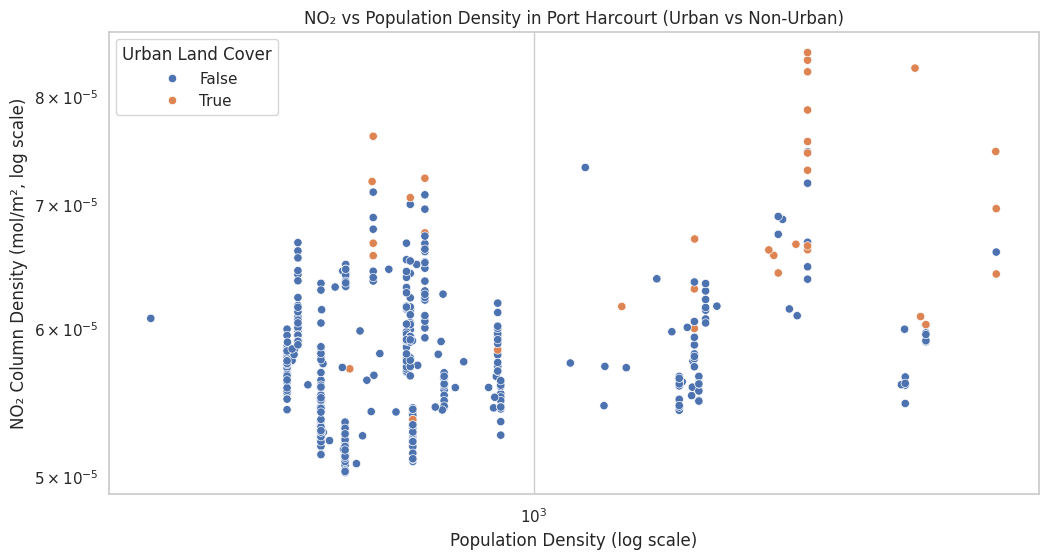

In [2]:
import ee
import geemap
import seaborn as sns
import matplotlib.pyplot as plt

# 🌍 Authenticate & initialize
ee.Authenticate()
ee.Initialize(project='urban-expansion-study-2025')

# 📍 Get Port Harcourt boundary using Rivers State
portharcourt = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Rivers')) \
    .geometry()

# 🛰️ Load Sentinel-5P NO₂ dataset
no2_collection = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select('NO2_column_number_density') \
    .filterBounds(portharcourt) \
    .filterDate('2019-01-01', '2024-01-01')

# ⏳ Generate monthly median images
def get_monthly_image(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    img = no2_collection.filterDate(start, end).median().clip(portharcourt)
    return img.set({'system:time_start': start.millis()})

dates = [(y, m) for y in range(2019, 2024) for m in range(1, 13)]
monthly_images = [get_monthly_image(y, m) for y, m in dates]
no2_monthly = ee.ImageCollection(monthly_images)

# 🎨 Visualization settings
vis = {
    'min': 0,
    'max': 0.0002,
    'palette': ['black', 'purple', 'blue', 'green', 'yellow', 'red']
}

# 🎞️ Create animated NO₂ GIF
gif_config = {
    'region': portharcourt,
    'dimensions': 600,
    'framesPerSecond': 3,
    'format': 'gif',
    'palette': vis['palette'],
    'min': vis['min'],
    'max': vis['max']
}

gif_url = no2_monthly.getVideoThumbURL(gif_config)
print("🟢 Animated NO₂ GIF:", gif_url)

# 🧍‍♂️ Load 2020 population
pop = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density") \
    .filter(ee.Filter.eq('system:index', 'gpw_v4_population_density_rev11_2020_30_sec')) \
    .first() \
    .clip(portharcourt)

# 🏙️ Load MODIS land cover and create urban mask (class 13)
modis = ee.Image("MODIS/006/MCD12Q1/2020_01_01").select('LC_Type1').clip(portharcourt)
urban_mask = modis.eq(13)

# 📊 Compute average NO₂
no2_mean = no2_collection.mean().clip(portharcourt)

# 📍 Sample 500 random points in Port Harcourt region
points = ee.FeatureCollection.randomPoints(region=portharcourt, points=500, seed=42)

# 🔄 Sample values
sampled = no2_mean.addBands(pop).addBands(urban_mask).sampleRegions(
    collection=points,
    scale=1000,
    geometries=True
)

# ⬇️ Convert to pandas DataFrame
df = geemap.ee_to_df(sampled)

# 🧼 Rename and clean
df = df.rename(columns={
    'NO2_column_number_density': 'NO2',
    'population_density': 'Population',
    'LC_Type1': 'Urban'
})
df['Urban'] = df['Urban'].astype(bool)

# 📈 Plot
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Population', y='NO2', hue='Urban')
plt.title('NO₂ vs Population Density in Port Harcourt (Urban vs Non-Urban)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population Density (log scale)')
plt.ylabel('NO₂ Column Density (mol/m², log scale)')
plt.legend(title="Urban Land Cover")
plt.show()


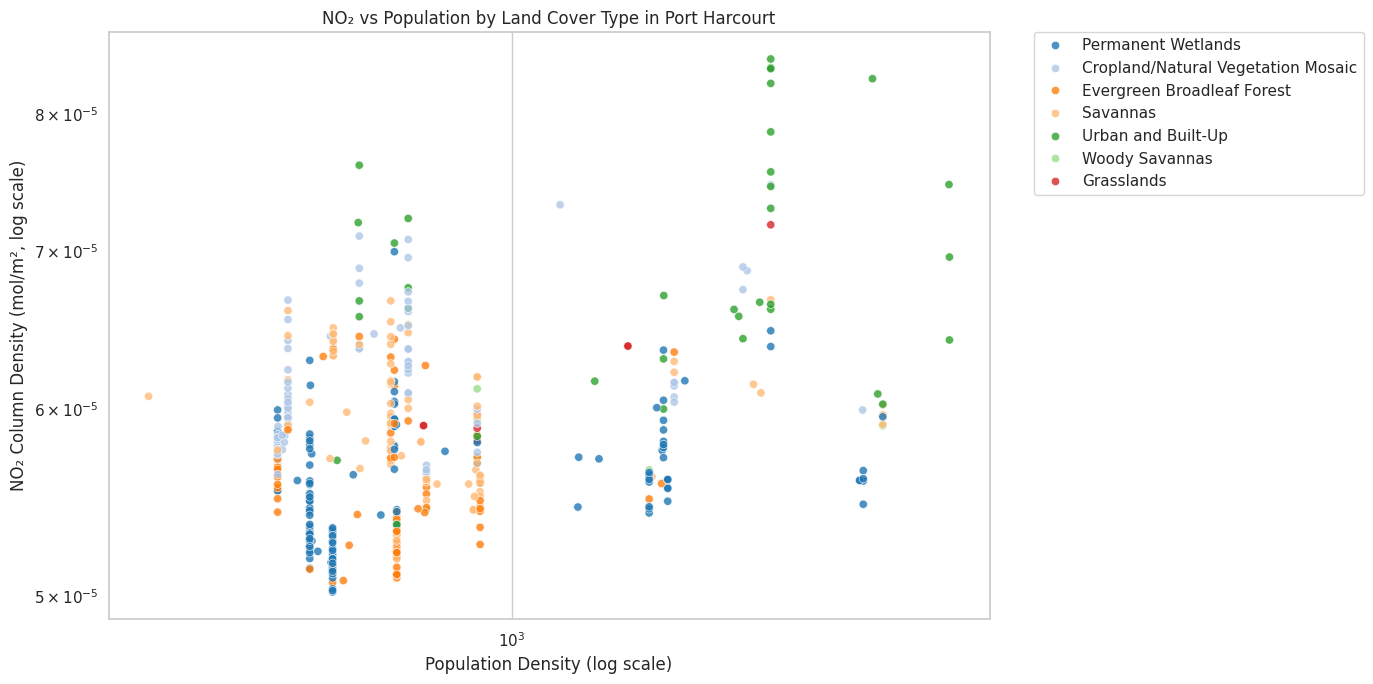

In [3]:
import ee
import geemap
import seaborn as sns
import matplotlib.pyplot as plt

# 🌍 Authenticate & initialize
ee.Authenticate()
ee.Initialize(project='urban-expansion-study-2025')

# 📍 Define Port Harcourt using Rivers State boundary
portharcourt = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Rivers')) \
    .geometry()

# ✅ Load MODIS Land Cover
modis = ee.Image("MODIS/006/MCD12Q1/2020_01_01").select('LC_Type1').clip(portharcourt)

# 🧍‍♂️ Population (2020)
pop = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density") \
    .filter(ee.Filter.eq('system:index', 'gpw_v4_population_density_rev11_2020_30_sec')) \
    .first() \
    .clip(portharcourt)

# 📊 NO₂ mean (2019–2024)
no2_collection = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select('NO2_column_number_density') \
    .filterBounds(portharcourt) \
    .filterDate('2019-01-01', '2024-01-01')

no2_mean = no2_collection.mean().clip(portharcourt)

# 📍 Generate sample points
points = ee.FeatureCollection.randomPoints(region=portharcourt, points=500, seed=42)

# 🧪 Sample all layers
sampled = no2_mean.addBands(pop).addBands(modis).sampleRegions(
    collection=points,
    scale=1000,
    geometries=True
)

# ⬇️ Convert to pandas
df = geemap.ee_to_df(sampled)

# 📖 Rename columns
df = df.rename(columns={
    'NO2_column_number_density': 'NO2',
    'LC_Type1': 'LandCover',
    'population_density': 'Population'
})

# 🏷️ MODIS Land Cover class labels
modis_classes = {
    0: 'Water',
    1: 'Evergreen Needleleaf Forest',
    2: 'Evergreen Broadleaf Forest',
    3: 'Deciduous Needleleaf Forest',
    4: 'Deciduous Broadleaf Forest',
    5: 'Mixed Forests',
    6: 'Closed Shrublands',
    7: 'Open Shrublands',
    8: 'Woody Savannas',
    9: 'Savannas',
    10: 'Grasslands',
    11: 'Permanent Wetlands',
    12: 'Croplands',
    13: 'Urban and Built-Up',
    14: 'Cropland/Natural Vegetation Mosaic',
    15: 'Snow and Ice',
    16: 'Barren or Sparsely Vegetated'
}

# 🧭 Map class numbers to labels
df['LandCoverClass'] = df['LandCover'].map(modis_classes)

# 📊 Plot
sns.set(style='whitegrid')
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df, x='Population', y='NO2', hue='LandCoverClass', palette='tab20', alpha=0.8)
plt.title('NO₂ vs Population by Land Cover Type in Port Harcourt')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population Density (log scale)')
plt.ylabel('NO₂ Column Density (mol/m², log scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

# 💾 Save for Medium or portfolio
plt.savefig("PHC_NO2_vs_Population_by_LandCover.png", dpi=300)
plt.savefig("PHC_NO2_vs_Population_by_LandCover.pdf")
plt.show()